In [47]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Tools for predictive data analysis. We will use the MinMaxScaler to normalize the price data 
from sklearn.preprocessing import MinMaxScaler 
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense

In [75]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980


In [49]:
# Changing the data structure to a dataframe with weekly price quotes
df["index1"] = range(1, len(df) + 1)
rownumber = df.shape[0]
lst = list(range(rownumber))
list_of_relevant_numbers = lst[0::7]
wdf = df[df["index1"].isin(list_of_relevant_numbers)]
wdf.head(5)

,High,Low,Open,Close,Volume,Adj Close,index1
Date,,,,,,,
2010-01-12,1143.810059,1131.770020,1143.810059,1136.219971,4716160000,1136.219971,7
2010-01-22,1115.489990,1090.180054,1115.489990,1091.760010,6208650000,1091.760010,14
2010-02-02,1104.729980,1087.959961,1090.050049,1103.319946,4749540000,1103.319946,21
2010-02-11,1080.040039,1060.589966,1067.099976,1078.469971,4400870000,1078.469971,28
2010-02-23,1108.579956,1092.180054,1107.489990,1094.599976,4521050000,1094.599976,35


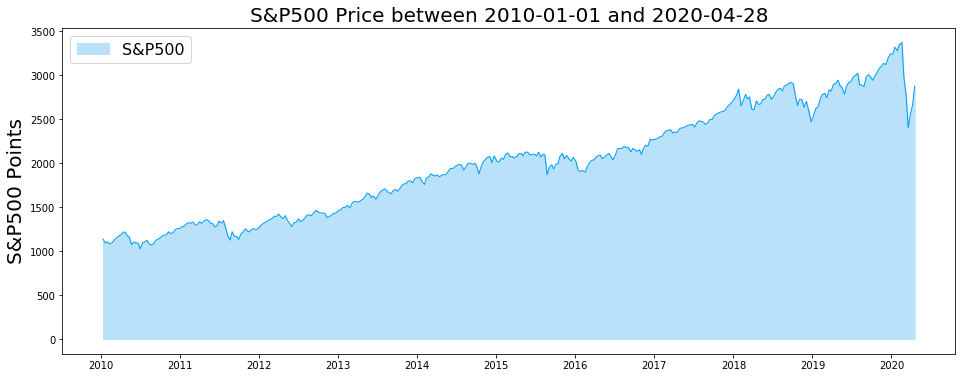

In [55]:
# Visualizing the data
register_matplotlib_converters()
years = mdates.YearLocator()
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = wdf.index
y = wdf["Close"]
ax1.fill_between(x, 0, y, color="#b9e1fa")
ax1.legend([stockname], fontsize=16)
plt.title(stockname + " Price between " + date_start + " and " + date_today, fontsize=20)
plt.plot(y, color="#039dfc", label="S&P500", linewidth=1.0)
plt.ylabel("S&P500 Points", fontsize=20)
plt.show()

In [56]:
# Create a new dataframe with only the Close column
data = wdf.filter(["Close"])

# Convert the dataframe to a numpy array and get the number of rows to train the model on 80% of the data
npdataset = data.values
training_data_length = math.ceil(len(npdataset) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)

# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
trainingdatasize = len(train_data)

for i in range(50, trainingdatasize):
    x_train.append(train_data[i - 50 : i, 0])  # contains 50 values 0-50
    y_train.append(train_data[i, 0])  # contains all other values

# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(246, 50, 1)
(246,)


In [57]:
# Configure the neural network model
model = Sequential()

# Model with 50 Neurons
# inputshape = 50 weekly price quotes
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [58]:
# Create a new array containing the test dataset
test_data = scaled_data[training_data_length - 50 :, :]

# Create the data sets x_test and y_test
x_test = []
y_test = npdataset[training_data_length:, :]
for i in range(50, len(test_data)):
    x_test.append(test_data[i - 50 : i, 0])

In [59]:
# Train the model
model.fit(x_train, y_train, batch_size=2, epochs=5)

Epoch 1/5
246/246 [==============================] - 6s 24ms/step - loss: 0.0103
Epoch 2/5
246/246 [==============================] - 5s 20ms/step - loss: 0.0011
Epoch 3/5
246/246 [==============================] - 5s 20ms/step - loss: 0.0012
Epoch 4/5
246/246 [==============================] - 5s 20ms/step - loss: 0.0013
Epoch 5/5
246/246 [==============================] - 5s 21ms/step - loss: 0.0012


In [63]:
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data, so that we get an array with multiple test datasets
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

In [67]:
# Get the root mean squarred error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE: ' + str(round(rmse, 1)))

# Get the meadian error (ME)
me = np.median(y_test-predictions)
print('ME: ' + str(round(me, 1)))

# Get the mean absolute error
mae = mean_absolute_error(y_test, predictions)
print('MAE: %f' % mae)

RMSE: 42.9
ME: 15.7
MAE: 124.151103


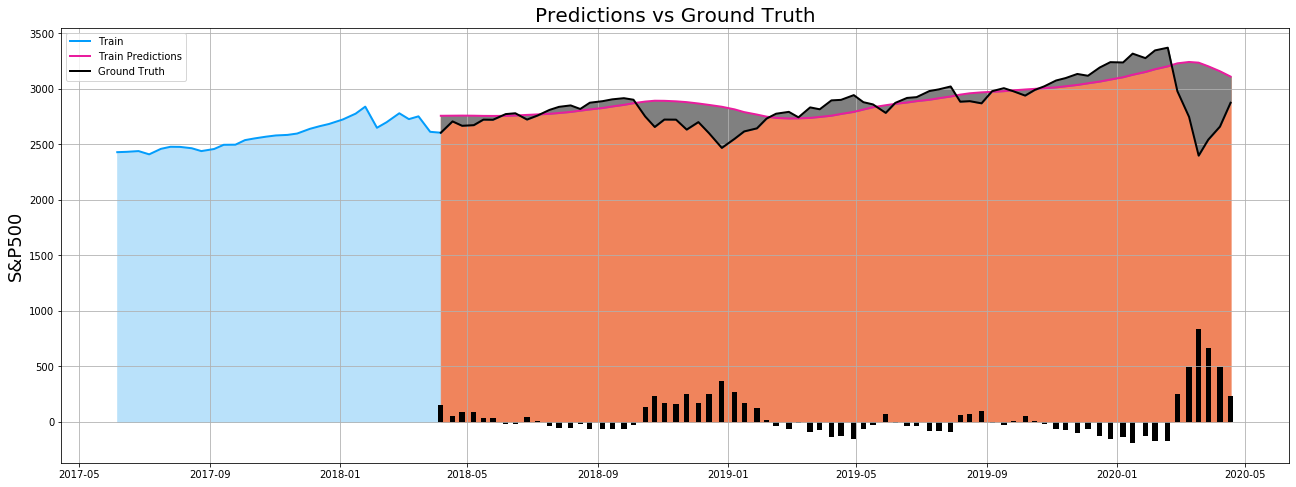

In [68]:
# The date from which on the date is displayed
display_start_date = "2017-06-01" 

# Add the difference between the valid and predicted prices
train = data[:training_data_length + 1]
valid = data[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 8), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=2.0)
plt.plot(yv["Predictions"], color="#E91D9E", linewidth=2.0)
plt.plot(yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Train Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="grey") 

# Create the bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

<BarContainer object of 74 artists>

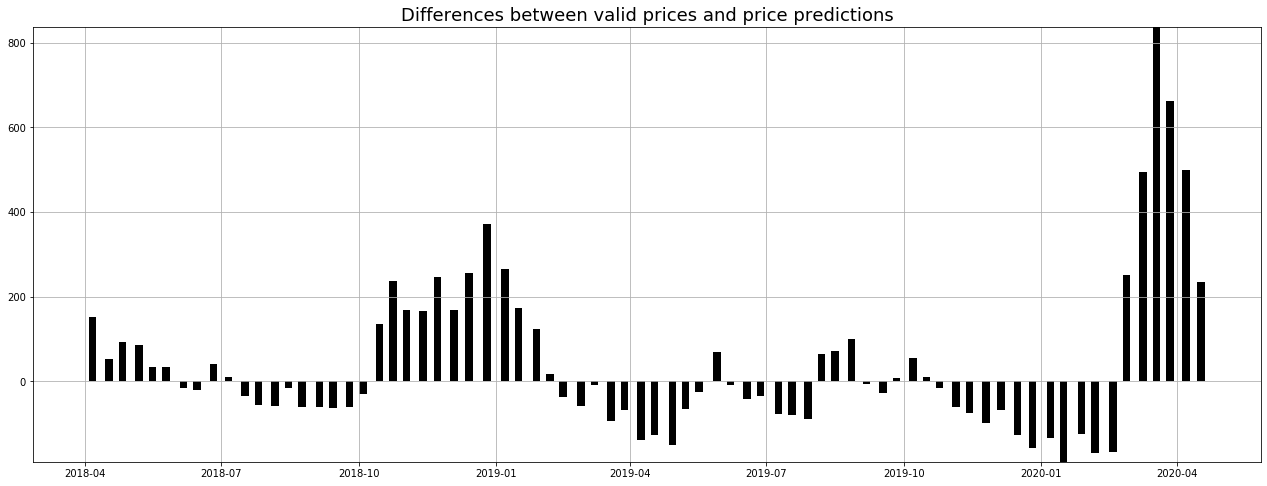

In [69]:
# Add the difference between the valid and predicted prices
diffdf = valid
differences = diffdf["Predictions"] - diffdf["Close"]
diffdf.loc[:, "difference"] = differences
x = diffdf.index
y = diffdf["difference"]


# Create the bar plot with the differences
plt.subplots(figsize=(22, 8))
plt.grid()
low = min(y)
high = max(y)
plt.ylim([low, high])
plt.title("Differences between valid prices and price predictions", fontsize=18)
plt.bar(x, y, width=5, color="black")

In [76]:
# Get fresh data until today and create a new dataframe with only the price data
price_quote = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
new_df = price_quote.filter(['Close'])

# Get the last 50 day closing price values and scale the data to be values between 0 and 1
last_50_weeks = new_df[-50:].values
last_50_weeks_scaled = mmscaler.transform(last_50_weeks)

# Create an empty list and append past 50 weeks
X_test = []
X_test.append(last_50_weeks_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price and undo the scaling
pred_price = model.predict(X_test)
pred_price = mmscaler.inverse_transform(pred_price)

# print the predicted price
date_next_week = date.today() + timedelta(days=7)
print('The price for ' + stockname + ' at ' + date_today + ' was: ' + str(round(new_df.at[df.index.max(), 'Close'])), 0)
print('The predicted ' + stockname + ' price at ' + str(date_next_week) + ' is: ' + str(round(pred_price[0, 0], 0)))

The price for S&P500 at 2020-04-28 was: 2878.0 0
The predicted S&P500 price at date 2020-05-05 is: 2840.0
